# CIFAR-10 for Deep Learning Workshop

---


This notebook is the first assignment in the deep learning workshop course in ben gurion university of the negev. It's purpose is to use deep learning tools to learn and identify the 10 classes avialable at the cifar-10 data set.
cifar-10 is a well known and used dataset in deep learning and ML studies and one can read more about it here: https://www.cs.toronto.edu/~kriz/cifar.html.

The notebook follows these steps:

1. EDA of the cifar-10 dataset and visualization.
2. Building and modifying ANN model.
3. Building a model using transfer learning.
4. Feature extraction from ANN model For the use of classic ML algorithms.




using colab and google drive - mount the drive to the notebook.

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Imports for all the sections of the notebook. one may choose to divide those but we like it better in one place.

In [0]:
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt


from os.path import join

import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, Callback
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model , model_from_json
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPool2D, BatchNormalization
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras import applications, regularizers , optimizers

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns


Using TensorFlow backend.


# 1. EDA: Exploratory Data Analysis
in this part we explore the cifar-10 dataset with some visualization.
The first part of any data science project is to get to know your data.

loading the dataset - as it is a well known and used dataset it is implemented into the keras libraries

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#We won't normalize those variables in order to call dataset_summary/test_img_summary
(X_train, Y_train), (X_test, Y_test) = (x_train, y_train), (x_test, y_test)

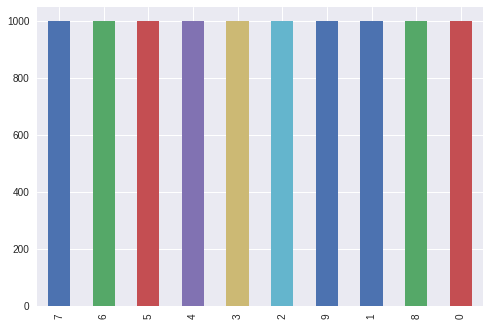

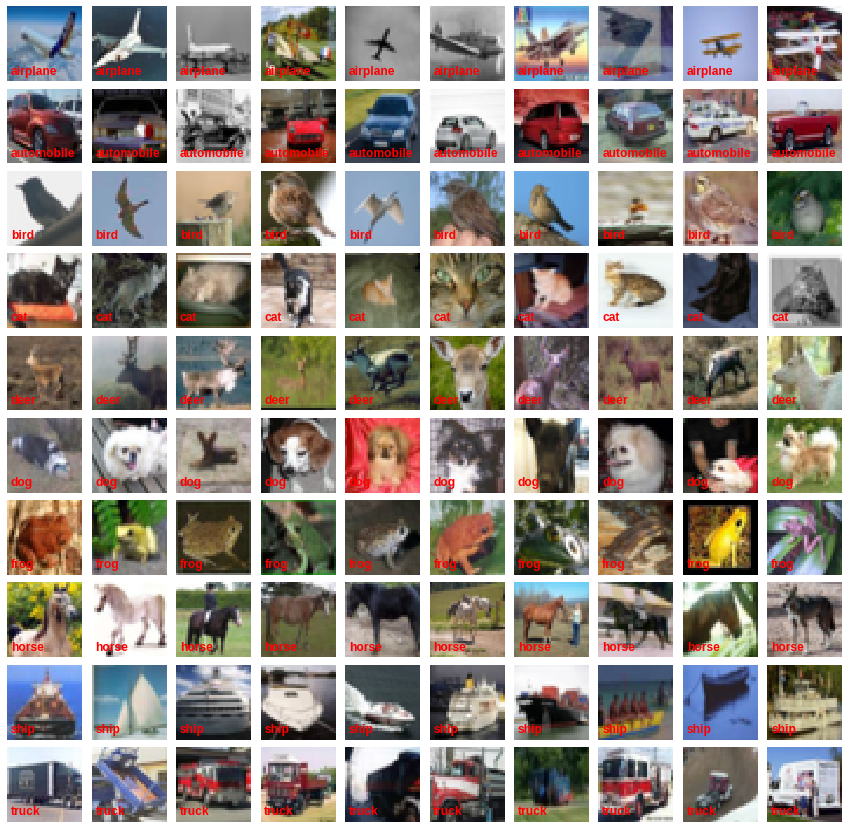

In [0]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def dataset_summary(x, y, labels=2, samples=2, figsize=(13,7)):
  label_list = load_label_names()
  y_df = pd.DataFrame(data = y, columns = ['Class'])
  y_df.iloc[:,-1].value_counts().plot(kind = 'bar')
 
  fig, ax = plt.subplots(nrows=labels,ncols=samples,figsize=figsize)
  fig.subplots_adjust(hspace=0.1, wspace=0.1)
  indxs = []
  for label in range(samples):
      indxs += random.sample(y_df.index[y_df['Class'] == label].tolist() , samples)
  for i in range(labels*samples):
      ax[i//samples,i%samples].imshow(x[indxs[i]],cmap='binary')
      ax[i//samples,i%samples].set_xticks([])
      ax[i//samples,i%samples].set_yticks([])
      ax[i//samples,i%samples].text(0.05, 0.1, label_list[int(y[indxs[i]])], color='red',transform=ax[i//samples,i%samples].transAxes,weight='bold')
     
  plt.show()
  
  

def test_img_summary(x, y, preds, labels=2, samples=2, figsize=(13,7)): 
  label_dict = load_label_names()
  fig, ax = plt.subplots(nrows=labels,ncols=samples,figsize=figsize)
  fig.subplots_adjust(hspace=0.1, wspace=0.1)
  for i in range(labels*samples):
      idx = random.randint(0, X_test.shape[0])
      ax[i//samples,i%samples].imshow(x[idx],cmap='binary')
      ax[i//samples,i%samples].set_xticks([])
      ax[i//samples,i%samples].set_yticks([])
      ax[i//samples,i%samples].text(0.05, 0.1, str(label_dict[preds[idx]]), transform=ax[i//samples,i%samples].transAxes,
                                   color='blue' if label_dict[y[idx][0]]==label_dict[preds[idx]] else 'red',weight='bold')
  plt.show()
    


  
dataset_summary(X_test, Y_test, 10, 10, (15,15))


lets see some details on out data set.

In [0]:
print('Number of training samples: {}'.format(x_train.shape[0]))
print('Number of test samples: {}'.format(x_test.shape[0]))
print('Sample dimension: {}'.format(x_train[0].shape))

Number of training samples: 50000
Number of test samples: 10000
Sample dimension: (32, 32, 3)


we confirm that the classes are indeed evenly balanced as noted in the datasets description.

Class distribution:
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))


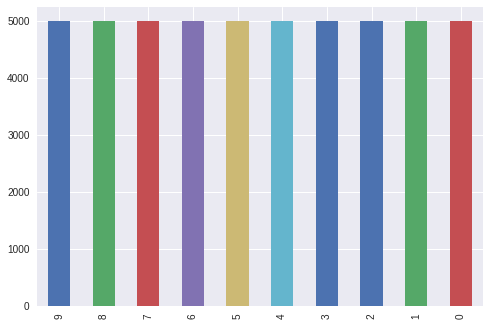

In [0]:
print('Class distribution:')
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))
y_train_df = pd.DataFrame(data = y_train, columns = ['Class'])
y_train_df.iloc[:,-1].value_counts().plot(kind = 'bar')

As we can see the data is balance, from every category we have the same amount of samples in the train and the test set.
next we will use a function to print examples from each category. 

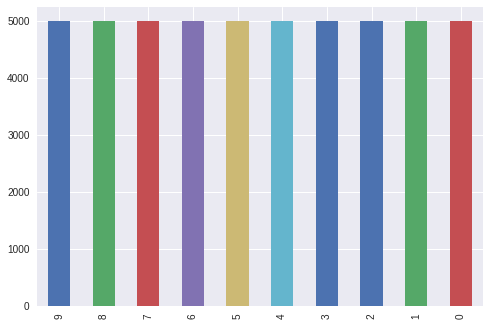

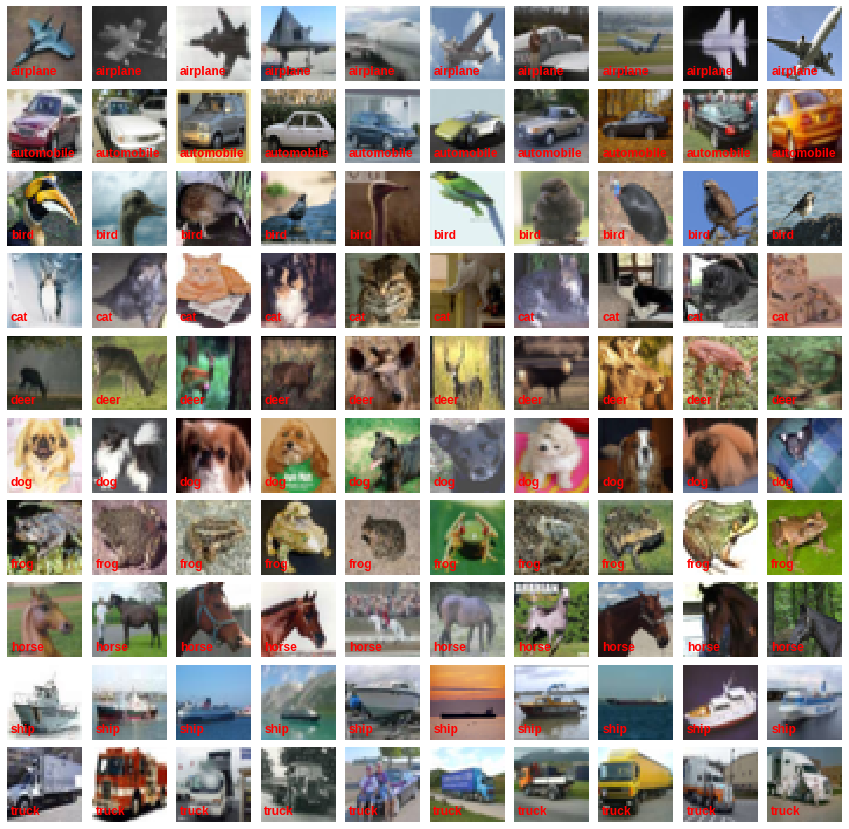

In [0]:
dataset_summary(x_train, y_train, 10, 10, (15,15))

and a closer look at the first sample so we can see the picture.

[6]


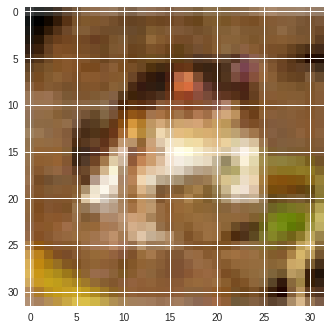

In [0]:
print(y_train[0])
plt.imshow(x_train[0],cmap='binary')

As we can see the pictures in the data set are not very clear  due to their dimension and size.

# Building and modifying ANN model



some functions and constants we are using further in the notebook.

In [0]:
img_width = 32
img_height = 32
channels = 3

split_prob = 0.8
batch_size = 128
epochs_num = 140




function to visualize the trainng and results of the model

In [0]:
def plot_history(history, model):
  plt.subplot(2, 1 , 1)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper right')
  plt.show()
  
  plt.subplot(2, 1 , 2)
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper right')
  plt.show()
  
  print('Training set accuracy: {}'.format(history.history['acc'][-1]))
  print('Validation set accuracy: {}'.format(history.history['val_acc'][-1]))
  print('Test set accuracy: {}'.format(model.evaluate(x_test, to_categorical(y_test))[-1]))
  print('-'*65)

  
def score_visualization(model,x_test,y_test, title):
  preds = model.predict(x_test)
  pred_cat = np.argmax(preds,axis=1)
  
  print('Model accuracy on test set is: {}%'.format(accuracy_score(y_test,pred_cat)*100))
  plt.xlabel('Prediction')
  plt.ylabel('True label')
  plt.title('Classification Result - {}:'.format(title))
  print(classification_report(y_test, pred_cat))
  sns.heatmap(confusion_matrix(y_test,pred_cat),cmap='Greens',annot=True, fmt='d')
  print('-'*65)


functions for saving and loading the model. you may change the model_path as needed

In [0]:
## TODO - change the current path
models_path = '/content/drive/My Drive/DLWS/'

def save_model(model,filename):
    json_string = model.to_json()
    path = join(models_path, filename)
    open(path + '_architecture.json', 'w').write(json_string)
    model.save_weights(path + '_model_weights.h5', overwrite=True)
    
# this is a helper function used to restore a keras NN model architecture and weights
def read_model(filename):
    path = join(models_path, filename)
    model = model_from_json(open(path + '_architecture.json', 'r').read())
    model.load_weights(path + '_model_weights.h5')
    return model

function to create our model and callbacks

In [0]:
def model_callbacks():
  def scheduler(epoch):
       if epoch < 70:
           return 0.01
       if epoch < 100:
           return 0.005
       return 0.001

  cp = ModelCheckpoint(models_path + "our_model_cp", save_best_only=True, monitor='val_loss', mode='min') 
  change_lr = LearningRateScheduler(scheduler)
  cbks = [change_lr,cp]
  return cbks
  

def our_model():
  model = Sequential()

  model.add(Conv2D(16,(3,3),activation='relu', kernel_initializer='he_normal',input_shape=(img_width,img_height,channels)))
  model.add(Conv2D(16,(3,3),activation='relu', kernel_initializer='he_normal'))
  model.add(MaxPool2D())
  model.add(BatchNormalization())

  model.add(Conv2D(32,(3,3),activation='relu',padding='same', kernel_initializer='he_normal'))
  model.add(Conv2D(32,(3,3),activation='relu',padding='same', kernel_initializer='he_normal'))
  model.add(MaxPool2D(padding='same'))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))

  model.add(Conv2D(64,(3,3),activation='relu', kernel_initializer='he_normal'))
  model.add(Conv2D(64,(3,3),activation='relu', kernel_initializer='he_normal'))
  model.add(Dropout(0.2))
  model.add(MaxPool2D())

  model.add(Flatten())
  model.add(Dense(10,activation='softmax', kernel_initializer='he_normal'))

  sgd = optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)
  model.compile(loss='categorical_crossentropy',optimizer=sgd ,metrics=['accuracy'])
  return model

running the model with no augmentaion or normaliztion

In [0]:
our_model = our_model()
history = our_model.fit(x=x_train, y=to_categorical(y_train), batch_size=batch_size, epochs=epochs_num, verbose=1, validation_split=0.2)


show traning process and results

In [0]:
our_model.summary()
plot_history(history, our_model)
score_visualization(our_model,x_test,y_test, 'Our Model')

here we are normalizing the data

In [0]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
         
x_train_mean, x_train_std =  np.mean(x_train, axis = 0), np.std(x_train, axis = 0)  
x_test_mean, x_test_std =  np.mean(x_test, axis = 0), np.std(x_test, axis = 0)

x_train = (x_train - x_train_mean) / x_train_std
x_test = (x_test - x_test_mean) / x_test_std


running the model after normalization. meaning we run the cell that normalize the data.

In [0]:
our_model2 = our_model()
history = our_model2.fit(x=x_train, y=to_categorical(y_train), batch_size=batch_size, epochs=epochs_num, verbose=1, validation_split=0.2)


show training process and results for basic model with normalization

In [0]:
our_model2.summary()
plot_history(history, our_model2)
score_visualization(our_model2,x_test,y_test, 'Our Model normalize')

creating a train - val sets by split_prob constant (in contrast to the the simple model, this split is neccessary for data augmentaion)

In [0]:
  
#Split the training data for train-validation set 
validation_split = np.random.rand(len(x_train)) < split_prob

x_train_data = x_train[validation_split]
x_val_data = x_train[~validation_split]

y_train_data = y_train[validation_split]
y_val_data = y_train[~validation_split]



This part is for data augmantion - we use this to add more sample with various shape to our data so our model will be more generic.
Worth noting - we are not performing vertical flip beacuse it is not suitable with the samples we have. Airplane for example has blue sky at the top most of the time and ship has blue sea in the bottom, fliping them might result in counfusion while tranining the model.


In [0]:
datagen = ImageDataGenerator(horizontal_flip=True,
                             width_shift_range=0.125,
                             height_shift_range=0.125,
                             fill_mode='constant',
                             cval=0.)



datagen.fit(x_train_data)

running a model with normaliztion and data augmantaion

In [0]:
our_model = our_model()
history = our_model.fit_generator(datagen.flow(x_train_data, to_categorical(y_train_data), batch_size),
                      steps_per_epoch = math.ceil(len(x_train_data) / batch_size),
                      epochs = epochs_num,
                      callbacks = model_callbacks(),
                      validation_data = (x_val_data, to_categorical(y_val_data)))



Epoch 1/140
313/313 [==============================] - 24s 75ms/step - loss: 1.7450 - acc: 0.3646 - val_loss: 1.5654 - val_acc: 0.4301
Epoch 2/140
313/313 [==============================] - 22s 70ms/step - loss: 1.4607 - acc: 0.4658 - val_loss: 1.4121 - val_acc: 0.4981
Epoch 3/140
313/313 [==============================] - 22s 70ms/step - loss: 1.3199 - acc: 0.5209 - val_loss: 1.2167 - val_acc: 0.5634
Epoch 4/140
313/313 [==============================] - 22s 70ms/step - loss: 1.2289 - acc: 0.5609 - val_loss: 1.0898 - val_acc: 0.6147
Epoch 5/140
313/313 [==============================] - 22s 70ms/step - loss: 1.1525 - acc: 0.5862 - val_loss: 1.0405 - val_acc: 0.6331
Epoch 6/140
313/313 [==============================] - 22s 70ms/step - loss: 1.0902 - acc: 0.6112 - val_loss: 1.0083 - val_acc: 0.6438
Epoch 7/140
313/313 [==============================] - 22s 70ms/step - loss: 1.0426 - acc: 0.6278 - val_loss: 0.9393 - val_acc: 0.6641
Epoch 8/140
313/313 [==============================] - 

show training process and results for basic model with normalization and augmentaion

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 16)        448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 16)        64        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
__________

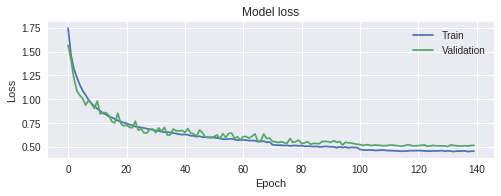

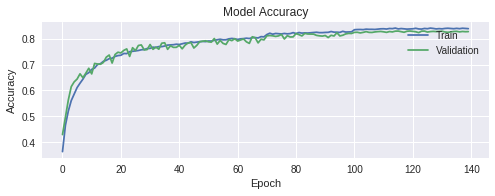

Training set accuracy: 0.8380216538192207
Validation set accuracy: 0.8267212978392866
10000/10000 [==============================] - 1s 130us/step
Test set accuracy: 0.8216
-----------------------------------------------------------------
Model accuracy on test set is: 82.16%
             precision    recall  f1-score   support

          0       0.78      0.88      0.83      1000
          1       0.89      0.93      0.91      1000
          2       0.78      0.75      0.77      1000
          3       0.73      0.59      0.65      1000
          4       0.82      0.83      0.82      1000
          5       0.81      0.69      0.75      1000
          6       0.78      0.92      0.84      1000
          7       0.83      0.87      0.85      1000
          8       0.90      0.88      0.89      1000
          9       0.88      0.87      0.88      1000

avg / total       0.82      0.82      0.82     10000

-----------------------------------------------------------------


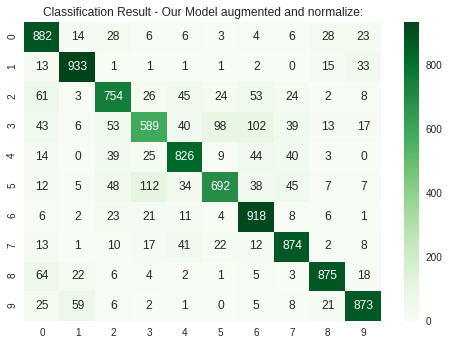

In [0]:
our_model.summary()
plot_history(history, our_model)
score_visualization(our_model,x_test,y_test, 'Our Model augmented and normalize')

# **Building a model using transfer learning:**
In this section we train by transfer learning method.
we used the vgg19 model as a base model.
we modify it to our problem and then train the model.

In [0]:
model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, channels))
model.summary()
for layer in model.layers:
    layer.trainable = False
    
x = model.layers[-6].output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation="softmax")(x)

# creating the final model 
trans_model = Model(inputs = model.input, outputs = predictions)


trans_model.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics=["accuracy"])


history = trans_model.fit(x=x_train, y=to_categorical(y_train), batch_size=batch_size, epochs=10, verbose=1, validation_split=0.2)


trans_model.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics=["accuracy"])

trans_model.evaluate(x=x_test, y=to_categorical(y_test), batch_size=batch_size, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

[0.662778427028656, 0.7767]

In [0]:
preds = trans_model.predict(x_test)
preds = np.argmax(preds,axis=1)

we show the training process and the results of our transfer model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

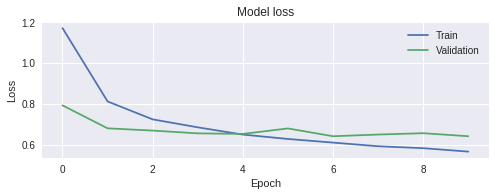

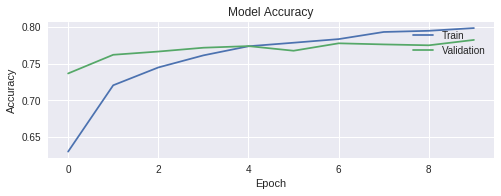

Training set accuracy: 0.798225
Validation set accuracy: 0.7821
10000/10000 [==============================] - 6s 583us/step
Test set accuracy: 0.7767
-----------------------------------------------------------------
-----------------------------------------------------------------


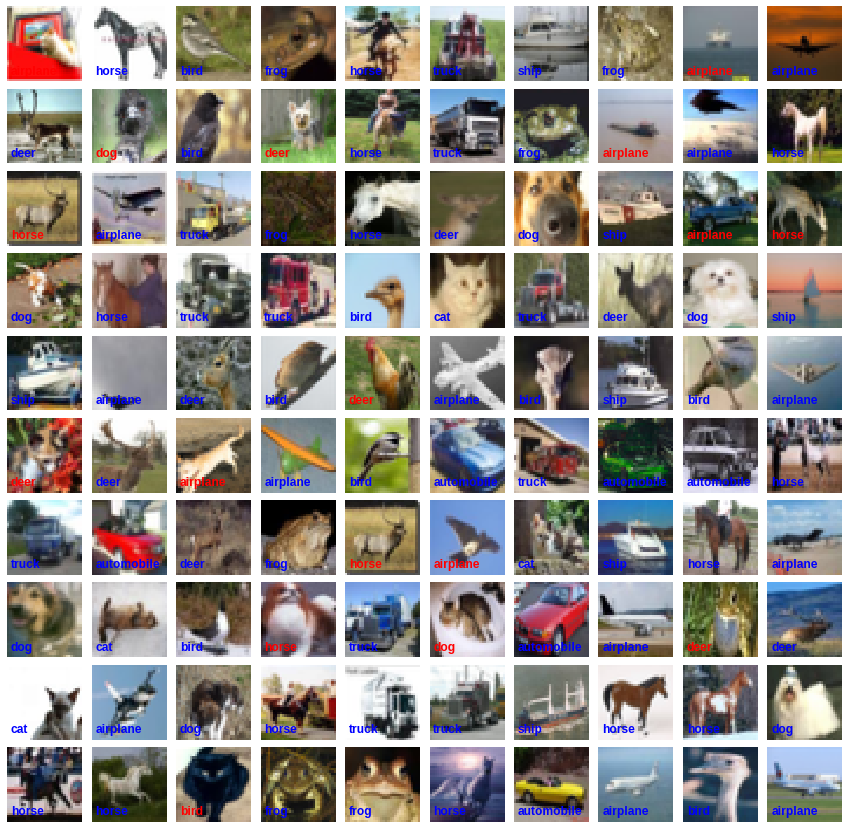

-----------------------------------------------------------------
Model accuracy on test set is: 77.66999999999999%
             precision    recall  f1-score   support

          0       0.73      0.90      0.80      1000
          1       0.82      0.91      0.86      1000
          2       0.75      0.68      0.71      1000
          3       0.65      0.56      0.60      1000
          4       0.67      0.82      0.74      1000
          5       0.72      0.66      0.69      1000
          6       0.86      0.79      0.82      1000
          7       0.79      0.85      0.82      1000
          8       0.93      0.80      0.86      1000
          9       0.90      0.81      0.85      1000

avg / total       0.78      0.78      0.78     10000

-----------------------------------------------------------------


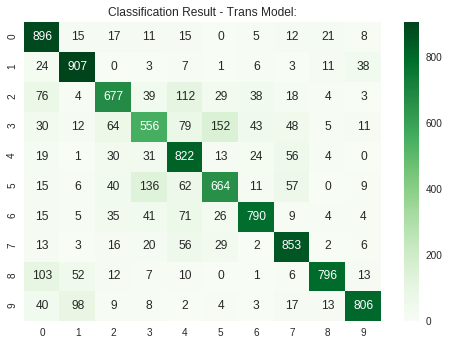

In [0]:
trans_model.summary()
print('-'*65)
plot_history(history, trans_model)
print('-'*65)
test_img_summary(X_test, Y_test, preds, 10, 10, (15,15))
print('-'*65)
score_visualization(trans_model,x_test,y_test, 'Trans Model')



we save the model for future use in the next section

In [0]:
save_model(trans_model, 'vgg19_transfer')

# 4. Feature extraction from ANN model and the use of classic ML algorithms
in this section we use an already trained DNN model as feature extractor for a novel ML algorithms and check the results.
before running this part of the notebook you should have a model stored using the save_model function.

we will load the model, extract the features and use them to train 3 novel ML model to compare and see the results.

loading and compile the model.
the evaluate method is there to see the results for the model we load and to check if it's the right model and to estimate the ML process results

In [0]:
model = read_model('vgg19_transfer')

model.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics=["accuracy"])
model.evaluate(x=x_test, y=to_categorical(y_test), batch_size=batch_size, verbose=1)

10000/10000 [==============================] - 5s 469us/step


[0.645594113445282, 0.7756]

slicing the model to use the second to last layer as features extractor.
to create the featrues we use the model to predict on the train set and then on the test set to create 2 list of features.

In [0]:
output = model.layers[-2].output
ftrs_model = Model(model.input, output)
ftrs_model.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics=["accuracy"])

ftrs_train = ftrs_model.predict(x_train)
ftrs_test = ftrs_model.predict(x_test)



lets check the shape of our new features.

In [0]:
print(ftrs_train.shape)
print(ftrs_test.shape)

(50000, 512)
(10000, 512)


**Using the features for ML models**


*   Logistic regression
*   random forest
* KNN



In [0]:
def ML_score_visualization(model,x_test,y_test, title):
  y_test_cat =y_test
  preds = model.predict(x_test)
  pred_cat = preds
  print('model accuracy on test set is: {}%'.format(accuracy_score(y_test_cat, pred_cat)*100))
  print(classification_report(y_test, pred_cat))
  sns.heatmap(confusion_matrix(y_test,pred_cat),cmap='Blues',annot=True, fmt='d')
  plt.xlabel('Prediction')
  plt.ylabel('True label')
  plt.title('Classification Result - {}:'.format(title))
  print('-'*65)

model accuracy on test set is: 78.96%
             precision    recall  f1-score   support

          0       0.81      0.83      0.82      1000
          1       0.87      0.89      0.88      1000
          2       0.75      0.72      0.74      1000
          3       0.63      0.61      0.62      1000
          4       0.74      0.76      0.75      1000
          5       0.70      0.69      0.69      1000
          6       0.81      0.84      0.83      1000
          7       0.84      0.83      0.83      1000
          8       0.88      0.88      0.88      1000
          9       0.86      0.85      0.85      1000

avg / total       0.79      0.79      0.79     10000

-----------------------------------------------------------------
0.87992
0.7896


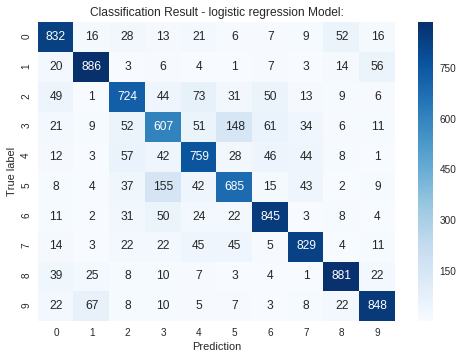

In [0]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

clf.fit(ftrs_train, y_train.ravel())
ML_score_visualization(clf,ftrs_test,y_test, 'logistic regression Model')
print(clf.score(ftrs_train, y_train.ravel()))
print(clf.score(ftrs_test, y_test.ravel()))


0.82016
0.7638
model accuracy on test set is: 76.38000000000001%
             precision    recall  f1-score   support

          0       0.76      0.83      0.79      1000
          1       0.86      0.87      0.87      1000
          2       0.72      0.63      0.67      1000
          3       0.60      0.57      0.58      1000
          4       0.71      0.75      0.73      1000
          5       0.67      0.68      0.67      1000
          6       0.78      0.84      0.81      1000
          7       0.82      0.77      0.80      1000
          8       0.86      0.85      0.85      1000
          9       0.84      0.86      0.85      1000

avg / total       0.76      0.76      0.76     10000

-----------------------------------------------------------------


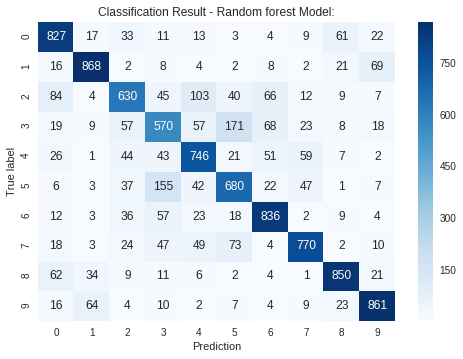

In [0]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=50, max_depth=6, criterion='entropy', min_samples_leaf=3)
clf.fit(ftrs_train, y_train.ravel())
print(clf.score(ftrs_train, y_train.ravel()))
print(clf.score(ftrs_test, y_test.ravel()))
ML_score_visualization(clf,ftrs_test,y_test, 'Random forest Model')

model accuracy on test set is: 78.0%
             precision    recall  f1-score   support

          0       0.80      0.85      0.82      1000
          1       0.86      0.88      0.87      1000
          2       0.72      0.72      0.72      1000
          3       0.59      0.63      0.61      1000
          4       0.72      0.77      0.74      1000
          5       0.68      0.67      0.67      1000
          6       0.82      0.81      0.82      1000
          7       0.87      0.79      0.83      1000
          8       0.88      0.87      0.87      1000
          9       0.89      0.83      0.86      1000

avg / total       0.78      0.78      0.78     10000

-----------------------------------------------------------------
0.8777
0.78


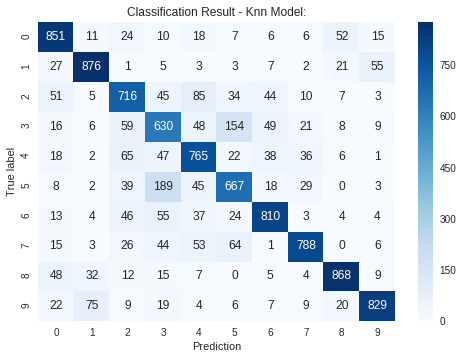

In [0]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(ftrs_train, y_train.ravel())
ML_score_visualization(clf,ftrs_test,y_test, 'Knn Model')
print(clf.score(ftrs_train, y_train.ravel()))
print(clf.score(ftrs_test, y_test.ravel()))

Thanks for reading. for all and any question you can call my partner tal ben-senior at 052-6437XXX day or night